# Trp FSs after clustering
This is a modification of the notebook given Chris (christoph.wehmeyer@fu-berlin.de), in this case we are going to use is to cluster the microstates based on the commute times.

In [1]:
import sys
import math
sys.path.append("/Users/suarezalvareze2/Documents/workspace/NMpathAnalysis/nmpath")
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pyemma
import mdtraj as md
from glob import glob

# My modules
from auxfunctions import *
from mfpt import *
from clustering import *
from nmm import NonMarkovModel, MarkovPlusColorModel

# Print 
from IPython.display import Markdown, display

## Auxiliary functions


In [2]:
def get_lagtime_from_array(lags, lagtime, dt=0.2):
    idx = np.argmin(np.abs(lags * dt - lagtime))
    return idx, lags[idx]

def printmd(string):
    display(Markdown(string))

def plot_t_AB(t_cut_values, t_min_list, t_max_list, t_AB_list):
    t_cut_values_ns = np.array(t_cut_values)*dt
    t_min_list_ns = np.array(t_min_list)*dt
    t_max_list_ns = np.array(t_max_list)*dt
    t_AB_list_ns = np.array(t_AB_list)*dt

    fig = plt.figure(figsize=(15,3))

    ax1 =  fig.add_subplot(131)
    ax1.plot(t_cut_values_ns , t_AB_list_ns, "-o")
    ax1.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax1.set_ylabel("$t_{AB}\mathrm{(ns)}$", fontsize = 18)
    #ax1.set_xlim(40,105)

    ax2 =  fig.add_subplot(132)
    ax2.plot(t_cut_values_ns, t_AB_list_ns/t_cut_values_ns, "-o",c="r")
    ax2.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax2.set_ylabel("$t_{AB} / t_{cut}$", fontsize = 18)
    #ax2.set_xlim(40,105)

    ax3 =  fig.add_subplot(133)
    ax3.plot(t_cut_values_ns, t_max_list_ns/t_cut_values_ns, "-o",c="g")
    ax3.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax3.set_ylabel("$t_{max} / t_{cut}$", fontsize = 18)
    #ax3.set_xlim(40,105)

    plt.show()

def cdf(pmf):
    mycdf=[]
    tot = 0
    for element in pmf:
        tot+= element
        mycdf.append(tot)
    return np.array(mycdf)


color_sequence = ['#d62728', '#ff9896', '#9467bd',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5', '#98df8a']

def confindence_interval_cdf(populations, totCounts, conf_interval=0.95, n_samples=100000):
    counts = np.round(np.array(populations)*totCounts)
    partialCounts = sum(counts)
    myarray = list(counts)+[totCounts-partialCounts]
    s=np.random.dirichlet(myarray,n_samples)

    s_cdf = []

    for line in s:
        s_cdf.append(cdf(line))
    s_cdf = np.array(s_cdf)

    s = np.transpose(s)
    s_cdf = np.transpose(s_cdf)

    minval = []
    maxval = []
    minvalcdf = []
    maxvalcdf = []

    for line in s:
        sorted_line = np.sort(line)
        minval.append(sorted_line[int(     (1-conf_interval)/2  * len(sorted_line))])
        maxval.append(sorted_line[int(  (1-(1-conf_interval)/2) * len(sorted_line))])

    for line in s_cdf:
        sorted_line = np.sort(line)
        minvalcdf.append(sorted_line[int(     (1-conf_interval)/2  * len(sorted_line))])
        maxvalcdf.append(sorted_line[int(  (1-(1-conf_interval)/2) * len(sorted_line))])
    
    return minvalcdf[:-1], maxvalcdf[:-1]

## Create a feature reader

We create a feature reader to obtain minimal distances between all residues which are not close neighbours. Feel free to map these distances to binary contacts or use inverse minimal residue distances instead. These coices usually work quite well.

In [3]:
#path = '/home/esuarez/Documents/DESHAWTRAJS/DESRES-Trajectory_2JOF-0-protein/2JOF-0-protein/'
#trajs = '2JOF-0-protein-*.dcd'

path = '/Users/suarezalvareze2/Documents/DESHAWTRAJS/DESRES-Trajectory_2JOF-0-protein/2JOF-0-protein/'
trajs = '2JOF-0-protein-*.dcd'

traj_files = [f for f in sorted(glob(path + trajs))]
pdb_file = path + 'protein.pdb'

features = pyemma.coordinates.featurizer(pdb_file)
features.add_residue_mindist()
source = pyemma.coordinates.source([traj_files], features=features, chunk_size=10000)

25-10-17 09:54:40 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[0] WARNING  Using all residue pairs with schemes like closest or closest-heavy is very time consuming. Consider reducing the residue pairs


## Discretization and MSM estimation

We start the actual analysis with a TICA projection onto two components on which we perform a k-means clustering. Then, we take a quick view on the implied timescale convergence, the 2D representation, and the clustering:

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

25-10-17 09:58:26 pyemma.coordinates.clustering.kmeans.KmeansClustering[3] INFO     Cluster centers converged after 31 steps.


A Jupyter Widget

A Jupyter Widget

/Users/suarezalvareze2/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


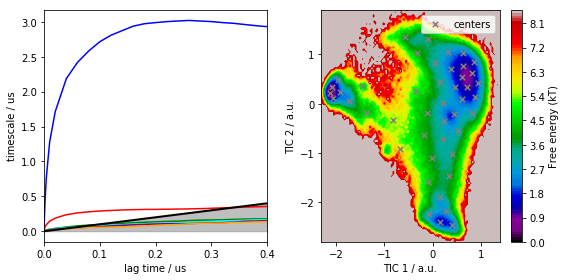

In [4]:
tica = pyemma.coordinates.tica(data=source, lag=5, dim=2).get_output()[0]
cluster = pyemma.coordinates.cluster_kmeans(tica, k=45, max_iter=100)

lags = np.asarray([1, 5, 10, 20, 50] + [i * 100 for i in range(1, 21)])
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
pyemma.plots.plot_implied_timescales(
    pyemma.msm.its(cluster.dtrajs, lags=lags, errors=None, nits=6),
    ylog=False, ax=axes[0], units='us', dt=2.0E-4)
pyemma.plots.plot_free_energy(*tica.T, ax=axes[1])
axes[1].scatter(*cluster.clustercenters.T, marker='x', c='grey', s=30, label='centers')
axes[1].legend()
axes[1].set_xlabel('TIC 1 / a.u.')
axes[1].set_ylabel('TIC 2 / a.u.')
fig.tight_layout()

# MSM estimation
msm = [pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=lag, dt_traj='0.0002 us') for lag in lags]

## Agglomerative Clustering from the transition matrix

Hierarchical agglomerative clustering using the Markovian commute time: $t_{ij} = \mathrm{MFPT}(i \rightarrow j)+ \mathrm{MFPT}(j \rightarrow i)$.

IMPORTANT: The goal of this clusterig is tho identify macrostates and not to use the best lag-time, the lag-time use for clustering could different from the one that would be appropiate for the final Markov model.


### Lag times to use

In [15]:
#lag_to_use = [1, 10, 100, 1000]
lag_to_use = [1]

lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]

# This are the t_cut intervals to explore (in lag-time units) with the lag times in "lag_to_use"
#range_per_lag = [[200,600], [200,350], [100,250], [30,200]]
range_per_lag = [[200,800]]


### Clustering

### Lag-time: 0.2ns

#### t_values:

t_cut: 40.00ns, t_min: 40.09ns, t_max: 7.34e+02ns, tAB: 584.97ns


/Users/suarezalvareze2/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


t_cut: 48.00ns, t_min: 51.73ns, t_max: 7.34e+02ns, tAB: 584.97ns
t_cut: 56.00ns, t_min: 59.18ns, t_max: 7.34e+02ns, tAB: 584.97ns
t_cut: 64.00ns, t_min: 67.17ns, t_max: 7.34e+02ns, tAB: 584.97ns
t_cut: 72.00ns, t_min: 91.77ns, t_max: 7.34e+02ns, tAB: 584.97ns
t_cut: 80.00ns, t_min: 91.77ns, t_max: 7.34e+02ns, tAB: 584.97ns
t_cut: 88.00ns, t_min: 91.77ns, t_max: 7.34e+02ns, tAB: 584.97ns
t_cut: 96.00ns, t_min: 101.71ns, t_max: 7.34e+02ns, tAB: 584.97ns
t_cut: 104.00ns, t_min: 105.96ns, t_max: 7.34e+02ns, tAB: 584.97ns
t_cut: 112.00ns, t_min: 114.25ns, t_max: 7.34e+02ns, tAB: 584.97ns
t_cut: 120.00ns, t_min: 137.90ns, t_max: 7.34e+02ns, tAB: 584.97ns
t_cut: 128.00ns, t_min: 137.90ns, t_max: 7.34e+02ns, tAB: 584.97ns
t_cut: 136.00ns, t_min: 137.90ns, t_max: 7.34e+02ns, tAB: 584.97ns
t_cut: 144.00ns, t_min: 162.66ns, t_max: 7.34e+02ns, tAB: 584.97ns
t_cut: 152.00ns, t_min: 162.66ns, t_max: 7.34e+02ns, tAB: 584.97ns


#### Observed clusters vs t_cut

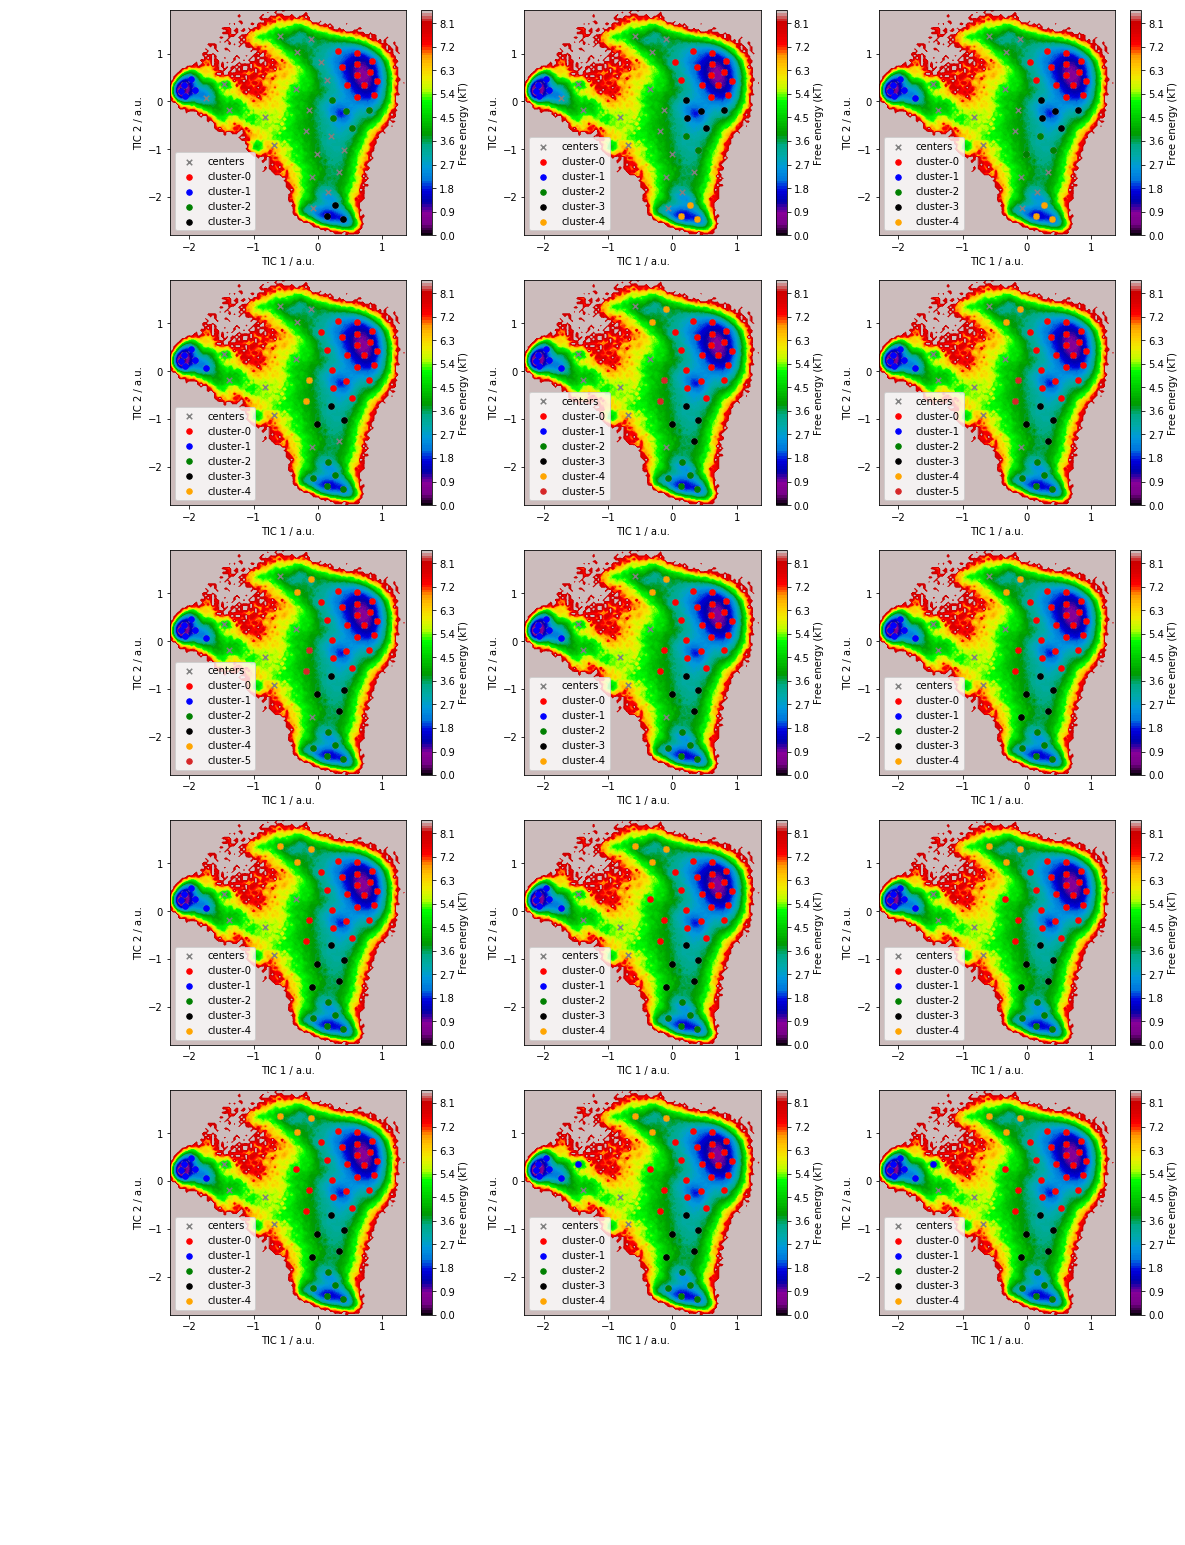

#### t_AB plots:

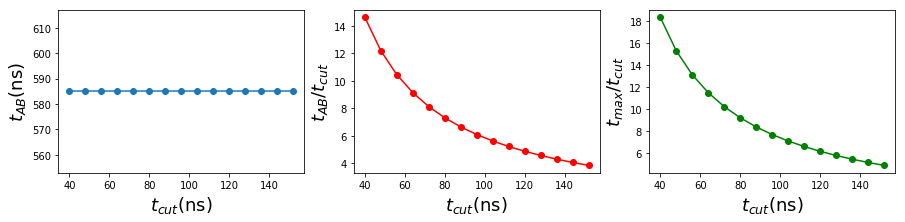

In [16]:
for k, index in enumerate(lag_index):
    K = msm[index].P
    dt = 0.2
    #---------------------
    printmd("### Lag-time: "+str(dt)+"ns")

    t_min_list=[]
    t_max_list=[]
    t_AB_list=[]

    big_clusters_list = []

    # t_cut range
    min_ = range_per_lag[k][0]
    max_ = range_per_lag[k][1]
    interval = (max_ - min_)//15 
    t_cut_values =  [min_+i for i in range(0,max_- min_,interval)][0:15]


    fig_n_cols = 3
    fig_n_rows = int(math.ceil(len(t_cut_values)/fig_n_cols))


    fig = plt.figure(figsize=(6*fig_n_cols, 4.8*fig_n_rows))

    printmd("#### t_values:")
    
    ini_clusters=None
    for ii, t_cut in enumerate(t_cut_values):

        big_clusters=[]
        big_clusters_index =[]

        # clustering
        #clusters, t_min, t_max, clustered_tmatrix = kinetic_clustering_from_tmatrix(K, t_cut=t_cut, verbose=False)
        clusters, t_min, t_max = kinetic_clustering2_from_tmatrix(K, t_cut=t_cut, verbose=False, ini_clusters=ini_clusters)


        t_min_list.append(t_min)
        t_max_list.append(t_max)

        for i, cluster_i in enumerate(clusters):
            if len(cluster_i) > 1:
                big_clusters.append(cluster_i)
                big_clusters_index.append(i)

        n_big = len(big_clusters)

        macrostates = biggest_clusters_indexes(big_clusters, n_pick=2)
        #macrostates_list.append([ clusters[macrostates[i]] for i in range(len(macrostates))])
        big_clusters_list.append(big_clusters)

        if n_big > 1:
            #tAB = markov_commute_time(clustered_tmatrix,[macrostates[0]],[macrostates[1]] )
            tAB = markov_commute_time(K,[macrostates[0]],[macrostates[1]] )
        else:
            tAB = 0.0
        t_AB_list.append(tAB)

        print("t_cut: {:.2f}ns, t_min: {:.2f}ns, t_max: {:.2e}ns, tAB: {:.2f}ns".format(t_cut*dt, t_min*dt, t_max*dt, tAB*dt))

        plt.subplot(fig_n_rows, fig_n_cols, ii+1)
        pyemma.plots.plot_free_energy(*tica.T)
        plt.scatter(*cluster.clustercenters.T, marker='x', c='grey', s=30, label='centers')
        plt.annotate("t_cut: {:.2f}ns".format(t_cut*dt), xy=(-0.8,-4))

        colors = ['red','blue','green','black','orange'] + color_sequence

        for i, cluster_i in enumerate(big_clusters):
            cluster_i_tica_xy = []
            for index in cluster_i:
                cluster_i_tica_xy.append(cluster.clustercenters[index])
            cluster_i_tica_xy = np.array(cluster_i_tica_xy)
            plt.scatter(*cluster_i_tica_xy.T, marker='o', c=colors[i], s=30, label='cluster-'+str(i))

        plt.legend(loc='lower left')
        plt.xlabel('TIC 1 / a.u.')
        plt.ylabel('TIC 2 / a.u.')
        
        ini_clusters = clusters

    printmd("#### Observed clusters vs t_cut")
    plt.show()

    printmd("#### t_AB plots:")
    plot_t_AB(t_cut_values, t_min_list, t_max_list, t_AB_list)

#     printmd("#### RMSD of the Macrostates:")
#     plot_rmsd_histogram_clusters(t_cut_values, big_clusters_list, rmsd, dt, dtrajs=cluster.dtrajs)

### Selecting t_cut = 71ns for mfpts calculations

In [17]:
dt = 0.0002 # in micro-sec

if 0 in big_clusters_list[5][1]:
    stateA = big_clusters_list[5][0]  #Unfolded
    stateB = big_clusters_list[5][1]  #Folded
else:
    stateA = big_clusters_list[5][1]  #Unfolded
    stateB = big_clusters_list[5][0]  #Folded

lag_to_use = lags[0:16:2]

lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]


msm_mfptAB = np.asarray([msm[lag_index[i]].mfpt(stateA, stateB) for i in range(len(lag_to_use))])
msm_mfptBA = np.asarray([msm[lag_index[i]].mfpt(stateB, stateA) for i in range(len(lag_to_use))])


## Fundamental Sequences

### Building the model

For the calculation of the fundamental sequences the microstates inside every macrostate (A and B) are merged together. Then the sates A and B are not longer composed by multiple microstates but by a single (big) one. 

In [18]:
nm_model = NonMarkovModel(cluster.dtrajs, stateA, stateB, lag_time=1, coarse_macrostates=True)

In [19]:
m_p_color = MarkovPlusColorModel(cluster.dtrajs, stateA, stateB, lag_time=1, coarse_macrostates=True, hist_length=100)

### Obtaining the FSs

In [20]:
mdFS, mdFSweights, tot_count_md = nm_model.empirical_weighted_FS()

nmFS, nmFSweights, _ = nm_model.weighted_FS()
mcFS, mcFSweights, _ = m_p_color.weighted_FS()



nm_model.markovian = True
msmFS, msmFSweights, _ = nm_model.weighted_FS() # lag=1

nm_model.lag_time = 10
msmFS_10, msmFSweights_10, _ = nm_model.weighted_FS() # lag=10

nm_model.lag_time = 50
msmFS_50, msmFSweights_50, _ = nm_model.weighted_FS() # lag=100


nm_model.lag_time

nm_model.markovian = False

### Comparing apples to apples

In [21]:
nmFSweights_temp = []
mcFSweights_temp = []

msmFSweights_temp = []
msmFSweights_temp_10 = []
msmFSweights_temp_50 = []



for i, element in enumerate(mdFS):
    
    # lag=1
    if element in nmFS:
        nmFSweights_temp.append(nmFSweights[nmFS.index(element)])
    else:
        nmFSweights_temp.append(0)
    
    if element in msmFS:
        msmFSweights_temp.append(msmFSweights[msmFS.index(element)])
    else:
        msmFSweights_temp.append(0)
    
    if element in mcFS:
        mcFSweights_temp.append(mcFSweights[mcFS.index(element)])
    else:
        mcFSweights_temp.append(0)
    
    # lag=10
    if element in msmFS_10:
        msmFSweights_temp_10.append(msmFSweights_10[msmFS_10.index(element)])
    else:
        msmFSweights_temp_10.append(0)
    
    # lag=50
    if element in msmFS_50:
        msmFSweights_temp_50.append(msmFSweights_50[msmFS_50.index(element)])
    else:
        msmFSweights_temp_50.append(0)


In [22]:
mdmin, mdmax = confindence_interval_cdf(mdFSweights, tot_count_md)

### Plot

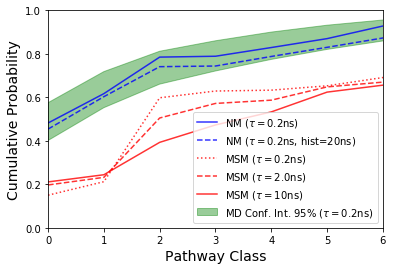

In [23]:
alpha=0.8
x = list( range(len(mdFS))  )

plt.fill_between(x, mdmin, mdmax, color='green', alpha=0.4, label=r'MD Conf. Int. 95% ($\tau=0.2$ns)')
plt.plot(x, cdf(nmFSweights_temp), label = r'NM ($\tau=0.2$ns)', color='blue', alpha=alpha)
plt.plot(x, cdf(mcFSweights_temp), '--',label = r'NM ($\tau=0.2$ns, hist=20ns)', color='blue', alpha=alpha)

plt.plot(x, cdf(msmFSweights_temp),':', label = r'MSM ($\tau=0.2$ns)', color='red', alpha=alpha)
plt.plot(x, cdf(msmFSweights_temp_10),'--', label = r'MSM ($\tau=2.0$ns)', color='red', alpha=alpha)
plt.plot(x, cdf(msmFSweights_temp_50),'-', label = r'MSM ($\tau=10$ns)', color='red', alpha=alpha)


plt.xticks([i for i in range(0,2*len(mdFS),1)])
plt.xlim([0,6])
plt.ylim([0,1])
plt.xlabel('Pathway Class', fontsize=14)
plt.ylabel('Cumulative Probability', fontsize=14)

plt.legend(loc='lower right')
plt.show()